## Generate data from sparse linear regression model

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(431)

def generate_data(m, n, s, sigma = 0.1):
    # Step 1: Generate X from Gaussian distribution
    X = np.random.randn(m, n)

    # Step 2: Create beta_star with first s entries as 1 and the rest 0
    beta_star = np.zeros(n)
    beta_star[:s] = 1
    #np.random.shuffle(beta_star)

    y = X @ beta_star + sigma * np.random.randn(m,)

    return X, y, beta_star


# evaluate the error
def l2_error(beta, beta_star):
    return np.linalg.norm(beta - beta_star)


# # Example usage:
# m, n, s = 100, 10, 3  # m samples, n features, s sparsity
# X, y, beta_star = generate_data(m, n, s)
# X.shape, y.shape, beta_star.shape  # Checking the shapes of the generated data



def plot_results(iterates, objective_values, beta_star):
    # Calculate the errors between iterates and beta_star
    errors = [l2_error(beta_t, beta_star) for beta_t in iterates]

    # Create Figure 1: Error vs. Iteration
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(errors)
    plt.xlabel('Iteration')
    plt.ylabel('Error (||beta_t - beta_star||)')
    plt.title('Error vs. Iteration')

    # Create Figure 2: Function Value vs. Iteration
    plt.subplot(1, 2, 2)
    plt.plot(objective_values)
    plt.xlabel('Iteration')
    plt.ylabel('Function Value')
    plt.title('Function Value vs. Iteration')

    plt.tight_layout()
    plt.show()

## Generate 200 data points with dimension $n=200$ and sparsity is $s = 5$.

In [2]:
m, n, s = 200, 100, 5  # m samples, n features, s sparsity
X, y, beta_star = generate_data(m, n, s)



## Method 1: Convex optimization via CVX

We use CVXPY to solve two convex optimization problems:

$\min \ell(\beta) + \lambda \cdot \|\beta\|_1 $,

$\min \ell(\beta)$ subject to $\| \beta \_1 \| \leq \lambda$.

In [3]:
import cvxpy as cp

def solve_cvx_reg(lambda_val, X, y):
    m, n = X.shape

    beta_cvx = cp.Variable(n)

    least_squares = cp.norm2(y - X @ beta_cvx)**2

    problem = cp.Problem(cp.Minimize(least_squares + lambda_val * cp.norm(beta_cvx, 1)))

    problem.solve()

    return beta_cvx.value

def solve_cvx_constraint(lambda_val, X, y):
    m, n = X.shape

    beta_cvx = cp.Variable(n)

    least_squares = cp.norm2(y - X @ beta_cvx)**2


    objective = cp.Minimize(cp.norm2(y - X @ beta_cvx)**2)
    constraints = [cp.norm(beta_cvx, 1) <= lambda_val]
    problem = cp.Problem(objective, constraints)
    problem.solve()
    return beta_cvx.value



beta_cvx_con = solve_cvx_constraint(5, X, y)
beta_cvx_reg = solve_cvx_reg(6, X, y)

print(f"L1-regularized problem -- Error of Convex optimization from CVXPY: \n{l2_error(beta_cvx_reg, beta_star)}\n")
print(f"L1-constrained problem -- Error of Convex optimization from CVXPY: \n{l2_error(beta_cvx_con, beta_star)}")

if max(l2_error(beta_cvx_reg, beta_star), l2_error(beta_cvx_con, beta_star)) < 0.05:
  print("\nThese two methods recovers the parameter acurrately \n")
else:
  print("\nThe error seems a bit large, perhaps you need to check the code or tune the hyperparameters")

L1-regularized problem -- Error of Convex optimization from CVXPY: 
0.031950590941983

L1-constrained problem -- Error of Convex optimization from CVXPY: 
0.02642879312110681

These two methods recovers the parameter acurrately 



# Method 2: Proximal Gradient Descent

The objective function is $\ell(\beta) + \lambda \| \beta\|_1$. The proximal operator reduces to soft-thresholding.

L1-regularized problem -- Error of Proximal gradient: 
0.027332228507959237


Proximal Gradient recovers the parameter acurrately 



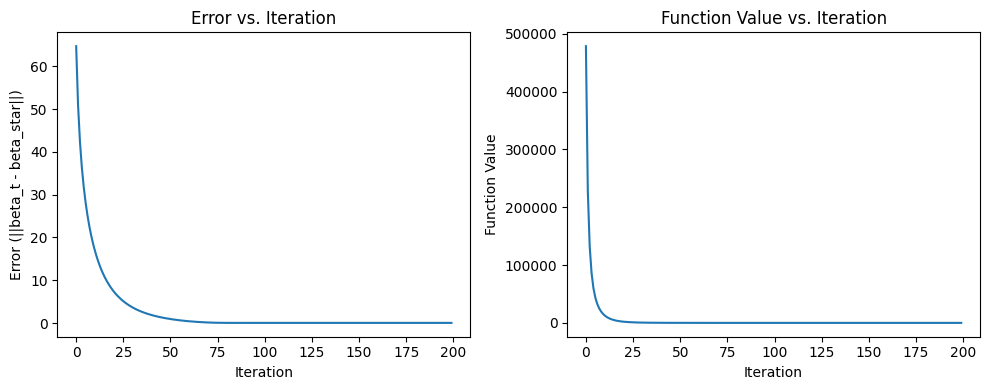

In [4]:
def soft_threshold(v, param):
    # Soft_thresholding function
    # Your code here
    func_val = np.zeros_like(v)

    mask1 = v > param
    mask2 = v < -param

    func_val[mask1] = v[mask1] - param
    func_val[mask2] = v[mask2] + param

    return func_val



def proximal_gradient(beta_0, X, y, alpha, lambda_, N_iter):
    # Initialize variables
    beta = beta_0
    objective_values = []  # To store the sequence of objective values
    iterates = []  # To store the sequence of iterates (beta values)

    for iteration in range(N_iter):
        # Compute the gradient of the objective function
        gradient = -2 * X.T.dot(y - X.dot(beta))

        # Update beta using soft-thresholding
        beta = soft_threshold(beta - alpha * gradient, alpha * lambda_)

        # Calculate the objective value and append to the list
        objective_value = np.linalg.norm(y - X.dot(beta))**2 + lambda_ * np.linalg.norm(beta, 1)
        objective_values.append(objective_value)

        # Append the current iterate (beta) to the list
        iterates.append(beta)

    return beta, iterates, objective_values


## Now let's test proximal gradient

# initialization
beta_init = 10 * np.ones(n)
lambda_prox = 3
stepsize = 0.001
N_iter = 200

beta_prox, beta_prox_seq, fun_prox_seq = proximal_gradient(beta_init, X, y, stepsize, lambda_prox, N_iter)

print(f"L1-regularized problem -- Error of Proximal gradient: \n{l2_error(beta_prox, beta_star)}\n")

if l2_error(beta_prox, beta_star) < 0.05:
  print("\nProximal Gradient recovers the parameter acurrately \n")
else:
  print("\nThe error seems a bit large, perhaps you need to check the code or tune the hyperparameters")

# generate plots
plot_results(beta_prox_seq, fun_prox_seq, beta_star)


# Method 3: Projected Gradient Descent

The optimization problem is $\min \ell(\beta)$ subject to $\| \beta \|_0 \leq t$ for some integer $t$.

L0-constrained problem -- Error of Projected gradient: 
0.02927328642834221


Projected Gradient recovers the parameter acurrately 



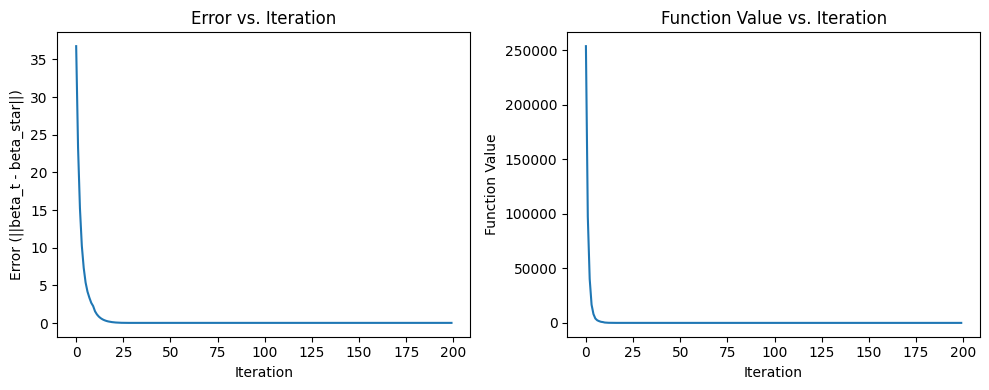

In [5]:
def project_largest_t_elements(beta, t):
    # Your code here

    sort_ind = np.argsort(beta)[:-t]
    proj_beta = beta.copy()
    proj_beta[sort_ind] = 0.0

    return proj_beta
    



def projected_gradient(beta_0, X, y, alpha, t, N_iter):
    # Initialize variables
    beta = beta_0
    objective_values = []  # To store the sequence of objective values
    iterates = []  # To store the sequence of iterates (beta values)

    for iteration in range(N_iter):
        # Compute the gradient of the objective function
        gradient = -2 * X.T.dot(y - X.dot(beta))

        # Update beta using soft-thresholding
        beta = project_largest_t_elements(beta - alpha * gradient, t)
        # print(beta)
        # Calculate the objective value and append to the list
        objective_value = np.linalg.norm(y - X.dot(beta))**2
        objective_values.append(objective_value)

        # Append the current iterate (beta) to the list
        iterates.append(beta)

    return beta, iterates, objective_values



## Now let's test proximal gradient

# initialization
beta_init = 10 * np.ones(n)
t = 10
stepsize = 0.001
N_iter = 200

beta_proj, beta_proj_seq, fun_proj_seq = projected_gradient(beta_init, X, y, stepsize, t, N_iter)

print(f"L0-constrained problem -- Error of Projected gradient: \n{l2_error(beta_proj, beta_star)}\n")

if l2_error(beta_proj, beta_star) < 0.05:
  print("\nProjected Gradient recovers the parameter acurrately \n")
else:
  print("\nThe error seems a bit large, perhaps you need to check the code or tune the hyperparameters")

# generate plots
plot_results(beta_proj_seq, fun_proj_seq, beta_star)

# Method 4: Frank-Wolfe Method

The optimization problem is $\min \ell(\beta)$ subject to $\| \beta \|_1 \leq \lambda$.

L1-constrained problem -- Error of Frank-Wolfe: 
0.029385438828408512


Frank-Wolfe recovers the parameter acurrately 



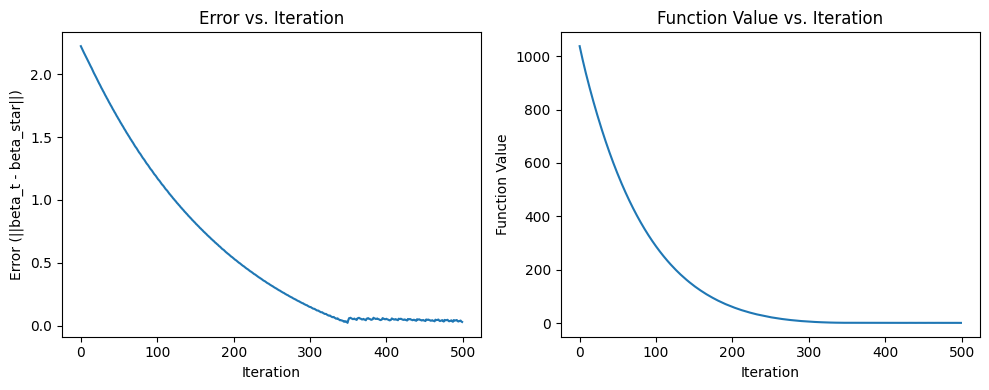

In [6]:
def update_direction(grad, lambda_):
    # Your code here
    m, n = X.shape

    new_dir = cp.Variable(n)

    objective = cp.Minimize(grad @ new_dir)
    constraints = [cp.norm(new_dir, 1) <= lambda_]
    problem = cp.Problem(objective, constraints)
    problem.solve()

    return new_dir.value


def frank_wolfe(beta_0, X, y, alpha, lambda_, N_iter):
    # Initialize variables
    beta = beta_0
    objective_values = []  # To store the sequence of objective values
    iterates = []  # To store the sequence of iterates (beta values)

    for iteration in range(N_iter):
        # Compute the gradient of the objective function
        gradient = -2 * X.T.dot(y - X.dot(beta))

        # Update direction
        direction = update_direction(gradient, lambda_)

        beta = (1-alpha) * beta + alpha * direction

        # print(beta)
        # Calculate the objective value and append to the list
        objective_value = np.linalg.norm(y - X.dot(beta))**2
        objective_values.append(objective_value)

        # Append the current iterate (beta) to the list
        iterates.append(beta)

    return beta, iterates, objective_values




## Now let's test proximal gradient

# initialization
beta_init = np.zeros(n)
t = 6
stepsize = 0.005
N_iter = 500

beta_fw, beta_fw_seq, fun_fw_seq = frank_wolfe(beta_init, X, y, stepsize, t, N_iter)

print(f"L1-constrained problem -- Error of Frank-Wolfe: \n{l2_error(beta_fw, beta_star)}\n")

if l2_error(beta_fw, beta_star) < 0.05:
  print("\nFrank-Wolfe recovers the parameter acurrately \n")
else:
  print("\nThe error seems a bit large, perhaps you need to check the code or tune the hyperparameters")

# generate plots
plot_results(beta_fw_seq, fun_fw_seq, beta_star)
